# V.1 Exploring the green reds

# a) Write a function that will plot a scatterplot matrix

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Convert dataframe value to array
    data = df.values
    # get data & variable number
    numdata, numvar = data.shape

    # output two objects, whole plot fig and a set of subplot axes 
    fig, axes = plt.subplots(nrows=numvar, ncols=numvar, figsize=(24,24))
    # close space between subplot
    fig.subplots_adjust(hspace=0, wspace=0)

    # Hide all ticks and labels
    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    # upper triangle coordinate
    tri_upper = []
    for row in range(numvar):
        for col in range(row + 1, numvar):
            tri_upper.append([row, col])

    # change quality value to color list
    cq = []
    for i in range(numdata):
        if (df['quality'].values[i] >= good_threshold):
            cq.append('green')
        elif (df['quality'].values[i] <= bad_threshold):
            cq.append('red')
        else:
            cq.append('none')
        
    # Plot the data
    for i, j in tri_upper:
        for x, y in [(i,j), (j, i)]:
            axes[x,y].scatter(data[:,y % numvar], data[:,x % numvar], s=3, c=cq)

    # Label the diagonal subplots...
    names = df.columns.values
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center', size=12)

    # show fig
    fig.show()
    if (save_plot == True):
        fig.savefig('scatter_matrix.png')

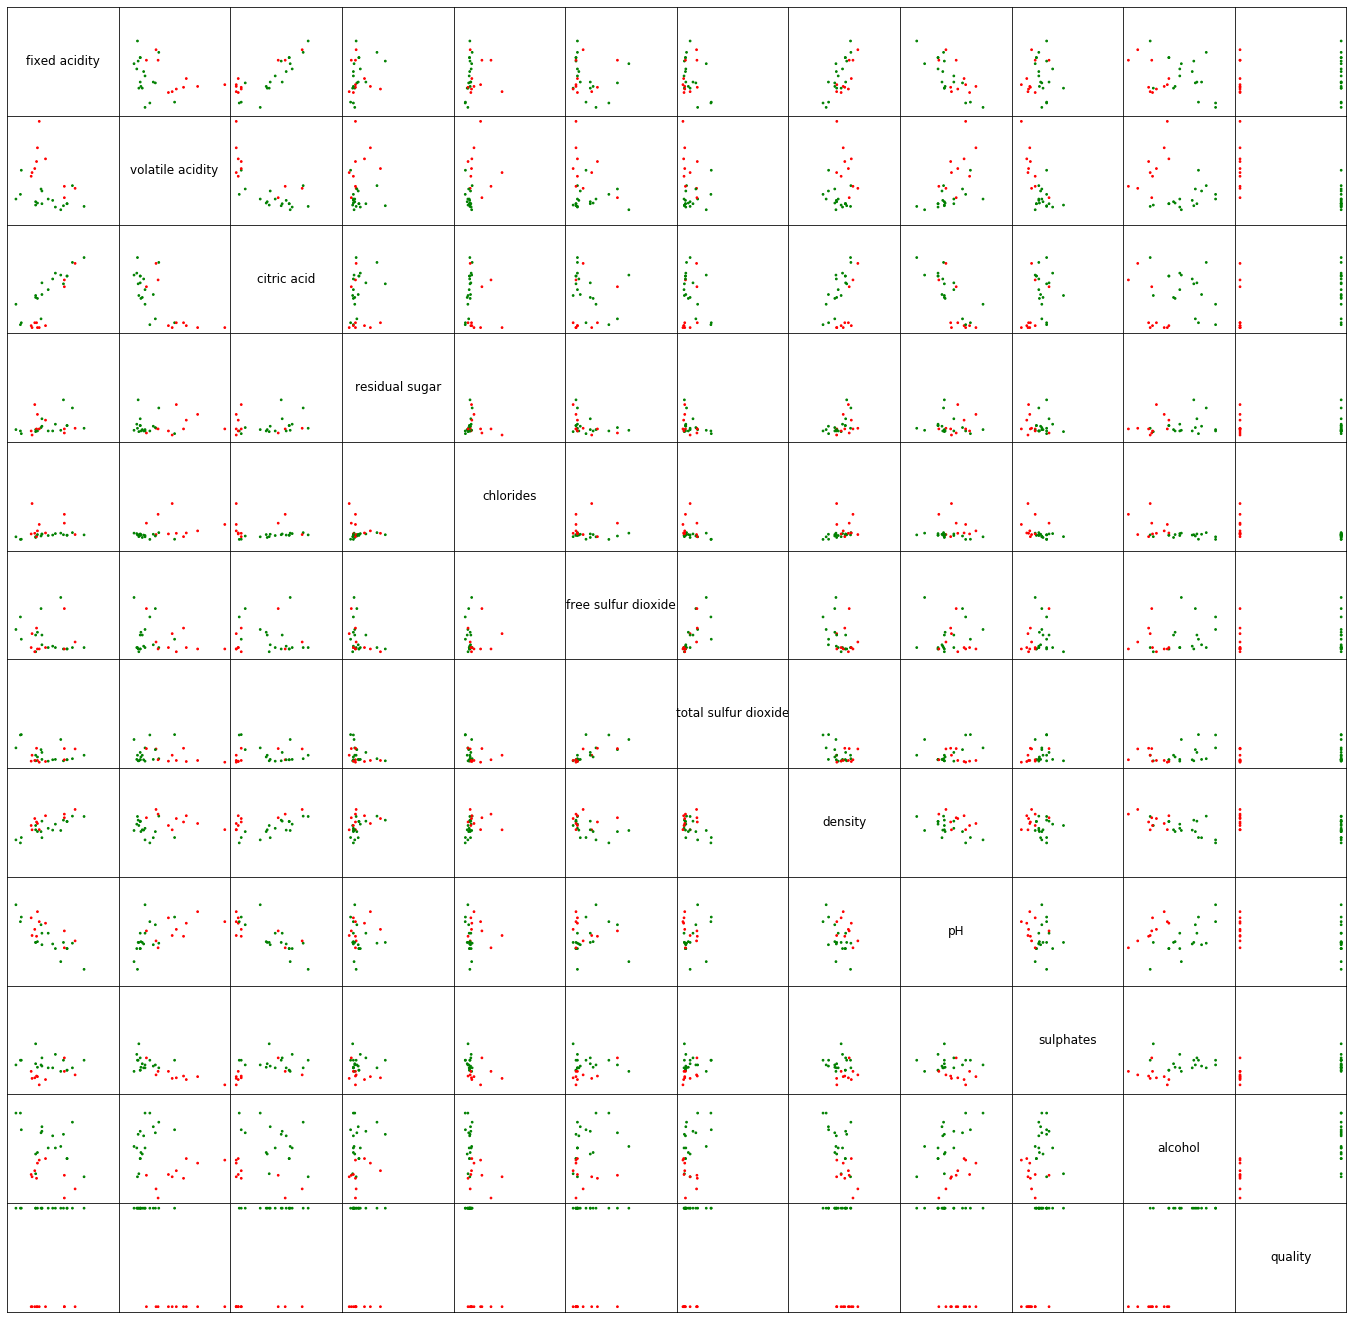

In [7]:
plot_scatter_matrix('winequality-red.csv', 8, 3, True)

# Referance

Basic Panda: https://ithelp.ithome.com.tw/articles/10191588

make scattorplot matrix: https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib

zip() in GeeksforGeeks: https://www.geeksforgeeks.org/zip-in-python/

save plot: https://pythonspot.com/matplotlib-save-figure-to-image-file/

# Doc

matplotlib.pyplot.scatter: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter

matplotlib.pyplot.subplots: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html

matplotlib.figure.Figure: https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html

numpy.triu_indices_from: https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu_indices_from.html

matplotlib.pyplot.annotate: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html

# b)  Question:
Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

# Answer:
I assume if the factors can be seperate good and bad by eyes, that's a useful factor to distinguish wine quality. My observation as follow:
pH & alcohol / alcohol & volatile acidity / density & citric acid

# V.2 Learning to perceptron

## a) & b) Perceptron Implementation

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [169]:
def errorCount(data, good, bad):
    error = 0
    for index, row in data.iterrows():
        if ((row['quality'] >= good and row['output'] == 0) or
            (row['quality'] <= bad and row['output'] == 1)):
            error += 1
    return error

In [170]:
def perceptron_train(data, epoch, learn_rate, good_thresh, bad_thresh): 
    cur_epoch = 0
    performance = []
    # Randomize weight
    weight = pd.DataFrame(
        {'bias' : [random.uniform(0, 1)], data.columns[1] : [random.uniform(0, 1)], data.columns[2] : [random.uniform(0, 1)]})
    # start trainning
    for _ in range(epoch):
        # iterate elements
        for index, row in data.iterrows():
            # update dot value
            dot_value = weight.dot(row[0:3]).values[0]
            # activation function
            if (dot_value > 0):
                data.loc[index, 'output'] = 1
            else:
                data.loc[index, 'output'] = 0
            # adjust weight
            if (row['quality'] >= good_thresh and data.loc[index, 'output'] == 0):
                weight += learn_rate * row[0:3]
            if (row['quality'] <= bad_thresh and data.loc[index, 'output'] == 1):
                weight -= learn_rate * row[0:3]
        # record performance
        cur_epoch += 1
        error = errorCount(data, good_thresh, bad_thresh)
        performance.append((cur_epoch, error, weight.values))
        if (error == 0):
            break ;
    return performance

## c) Generate performance plot

In [204]:
def plot_performace(performance, data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # color in scatter plot
    cq = []
    for i in range(len(data)):
        if (data['quality'].values[i] >= good_thresh):
            cq.append('green')
        elif (data['quality'].values[i] <= bad_thresh):
            cq.append('red')
        else:
            cq.append('none')
    
    # some epoch error check
    if (epoch > len(performance)):
        epoch = len(performance)
    epochnum = epoch
    if (epoch == -1):
        epochnum = len(performance)
    
    # set scatter plot x and y
    er = []
    ep = []
    for i in range(epochnum):
        ep.append(performance[i][0])
        er.append(performance[i][1])
    
    # draw scatter plot
    ax[0].plot(ep, er, label='Errors as a function of epoch')
    ax[0].set(xlabel='Epoch', ylabel='Error')
    
    # set boundary
    x_min = data.iloc[:,1].min()
    x_max = data.iloc[:,1].max()
    y_min = data.iloc[:,2].min()
    y_max = data.iloc[:,2].max()
    x_rg = x_max - x_min
    y_rg = y_max - y_min
    ax[1].set_xlim([x_min - 0.05 * x_rg, x_max + 0.05 * x_rg])
    ax[1].set_ylim([y_min - 0.05 * y_rg, y_max + 0.05 * y_rg])
 
    # get decision boundary line equation
    wx = performance[epoch][2][0, 1]
    wy = performance[epoch][2][0, 2]
    b = performance[epoch][2][0, 0]
    slope = -wx/wy
    intercept = -b/wy
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept
    
    # draw Drecision boundary
    ax[1].plot(x_coords, y_coords, 'b--', label='Decision boundary')
    ax[1].fill_between(x_coords, y_coords, y_min - 0.05 * y_rg, color='pink')
    ax[1].fill_between(x_coords, y_coords, y_max + 0.05 * y_rg, color='palegreen')
    ax[1].scatter(data.iloc[:,1].values,data.iloc[:,2].values, c=cq, s=10)
    ax[1].set(xlabel=data.columns[1], ylabel=data.columns[2])

    fig.show()
    
    if save_plot:
        fig.savefig("Performance Plot: " + data.columns[1] + " & " + data.columns[2])

In [205]:
def build_data(wine_data, factor1, factor2, good_thresh, bad_thresh):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")

    # build dataFrame
    data = df[[factor1, factor2, 'quality']]
    data.insert(0, 'bias', 1)
    data.insert(4, 'output', random.randint(0, 1))

    # Only catch data over or below threshold
    for i in range(numdata):
        if (data.loc[i, 'quality'] < good_thresh and data.loc[i, 'quality'] > bad_thresh):
            data = data.drop([i])
    return data

In [226]:
data = build_data("winequality-red.csv", 'density', 'citric acid', 8, 3)

In [227]:
performance = perceptron_train(data, 20000, 1, 8, 3)

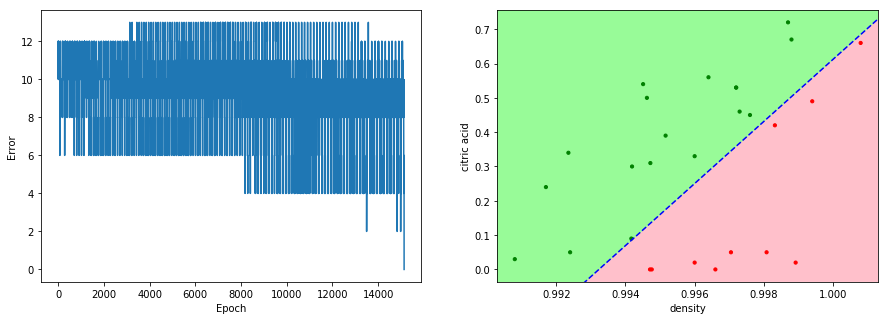

In [228]:
plot_performace(performance, data, 8, 3, -1, True)

# Referance
## Perceptron

Perceptron basic: https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53

Perceptron algorithm: https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975

19-line Line-by-line Python Perceptron: https://medium.com/@thomascountz/19-line-line-by-line-python-perceptron-b6f113b161f3

## Python

Find the Angle Between Two Vectors: https://www.wikihow.com/Find-the-Angle-Between-Two-Vectors

law of cosines: https://www.mathopenref.com/lawofcosinesproof.html

Pandas Data Selection: https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

loading, editing, and viewing data: https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/

iter row in DataFrame: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

pandas iteration: https://www.tutorialspoint.com/python_pandas/python_pandas_iteration.htm

## Plot

Graph plotting: https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/

Plot Straight line: https://scriptverse.academy/tutorials/python-matplotlib-plot-straight-line.html

## Doc

pandas insert: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html

pandas.DataFrame: https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.html

pandas.DataFrame.drop: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

pandas.DataFrame.dot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dot.html

pandas.DataFrame.add: http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.add.html

## d) Learning more efficiently

# V.3 My fair ADALINE

## a) What's gradient descent and ADALINE?

## b) & C) implement ADALINE

# Referance
Perceptron, Adaline, and neural network: https://sebastianraschka.com/faq/docs/diff-perceptron-adaline-neuralnet.html

Gradient Descent Rule for Linear Regression and Adaline: http://rasbt.github.io/mlxtend/user_guide/general_concepts/linear-gradient-derivative/

Gradient Descent and Stochastic Gradient Descent: http://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization/

機器學習(3)--適應線性神經元與梯度下降法(Adaline neuron and Gradient descent): http://arbu00.blogspot.com/2017/02/3-adaline-neuron-and-gradient-descent.html

The "Python Machine Learning (1st edition)" book code repository and info resource: https://github.com/rasbt/python-machine-learning-book

人工神經網路(1)--使用Python實作perceptron(感知器): http://arbu00.blogspot.com/2016/11/1-pythonperceptron.html